### Exploratory research of genre dependence on profitability. 
1. remove NaNs - at the end decided to remove all
2. calculate 'profitability = (revenue - cost)', and do expolatory research
3. remove outliers from 'profitability' and 'owtheathers' before scaling
4. scale/normalize
5. cluster events into groups and apply linear regression models for each cluster

55.4+/-1.0% of movies do not generate profit on domestic market (distributed all over genre).
Star Wars rule, of course!
Attempt to find early release predictor would require more details (features) and statistics (there are only several movies per director/actor). 

In [1]:
from pymongo import MongoClient
import dateutil.parser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties.umath import * 
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.cluster import MeanShift
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms

In [2]:
%matplotlib inline
pd.set_option('max_columns',200)

In [3]:
client = MongoClient()
db = client.boxofficemojo
collection = db.movies
cursor = collection.find()
print 'Number of events = %d' % cursor.count()

Number of events = 14006


In [4]:
df = pd.DataFrame(list(cursor))

In [5]:
df1 = df.ix[:,3:].copy()

In [6]:
remove = ['Producer','Writer','_id']
for item in remove:
    if item in df1:
        del df1[item]

In [7]:
print df1.shape
df1.head()

(14006, 11)


,Distributor,Domestic Total,Genre:,MPAA Rating,OWtheaters,Production Budget,Release Date,Runtime,TLG,openWDG,title
0,Buena Vista,NaN,Sci-Fi Fantasy,PG-13,59982,245000000,"December 18, 2015",136,935518389,247966675,Star Wars: The Force Awakens (2015)
1,Fox,749766139,Sci-Fi Adventure,PG-13,22313,NaN,"December 18, 2009",160,760507625,77025481,Avatar (2009)
2,Paramount,600788188,Romance,PG-13,10710,200000000,"December 19, 1997",194,658672302,28638131,Titanic (1997)
3,Universal,652270625,Sci-Fi Horror,PG-13,48855,150000000,"June 12, 2015",124,652270625,208806270,Jurassic World (2015)
4,Buena Vista,623357910,Action / Adventure,PG-13,47698,220000000,"May 4, 2012",142,623357910,207438708,Marvel's The Avengers (2012)


In [8]:
def transform_column_names(dataframe):
    """Convert column names in a dataframe to lower case and join multi-word names to a single-word name"""
    
    dataframe.columns = [x.lower() for x in dataframe.columns]
    dataframe.columns = [x.replace(" ","").strip(":") for x in dataframe.columns]
    return dataframe.columns

In [9]:
df1.columns = transform_column_names(df1)

In [10]:
df1.head()

,distributor,domestictotal,genre,mpaarating,owtheaters,productionbudget,releasedate,runtime,tlg,openwdg,title
0,Buena Vista,NaN,Sci-Fi Fantasy,PG-13,59982,245000000,"December 18, 2015",136,935518389,247966675,Star Wars: The Force Awakens (2015)
1,Fox,749766139,Sci-Fi Adventure,PG-13,22313,NaN,"December 18, 2009",160,760507625,77025481,Avatar (2009)
2,Paramount,600788188,Romance,PG-13,10710,200000000,"December 19, 1997",194,658672302,28638131,Titanic (1997)
3,Universal,652270625,Sci-Fi Horror,PG-13,48855,150000000,"June 12, 2015",124,652270625,208806270,Jurassic World (2015)
4,Buena Vista,623357910,Action / Adventure,PG-13,47698,220000000,"May 4, 2012",142,623357910,207438708,Marvel's The Avengers (2012)


###1. Removing NaN values:

In [11]:
# Counting NaN values per column:
NaNs_per_col = df1.isnull().sum(axis=0)
print 'Number of NaNs per column: '
print
print NaNs_per_col

Number of NaNs per column: 

distributor             3
domestictotal         973
genre                   3
mpaarating              3
owtheaters           3523
productionbudget    11157
releasedate             3
runtime               376
tlg                     4
openwdg              1883
title                   0
dtype: int64


(-0.40000000000000002, 10.4, 0.0, 11157.0)

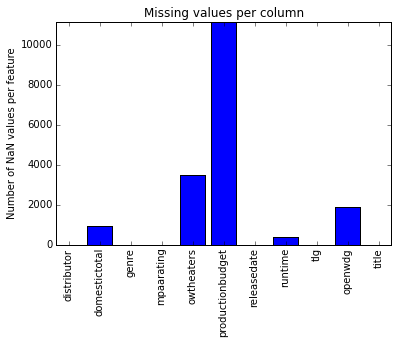

In [12]:
plt.bar(range(len(NaNs_per_col)),NaNs_per_col, align='center')
plt.xticks(range(len(NaNs_per_col.index.tolist())),NaNs_per_col.index.tolist(), rotation=90)
plt.ylabel('Number of NaN values per feature')
plt.title('Missing values per column')
plt.axis('tight')
# Vast majority of NaNs in 'productionbudget', a variable neede to calculate 
#profitability = domestictotal - productionbudget

In [13]:
# Histogramming number of missing features per row; 
# key - number of missing features per row,
# value - number of events
# e.g., (0: 2437,) 2437 events have all the features

NaNs_per_row = df1.isnull().sum(axis=1)
row_NaN = dict()
for row in NaNs_per_row:
    row_NaN[row] = row_NaN.get(row,0) + 1
print  row_NaN

{0: 2437, 1: 7225, 2: 2531, 3: 1638, 4: 163, 5: 9, 10: 3}


(-0.40000000000000002, 10.4, 0.0, 7225.0)

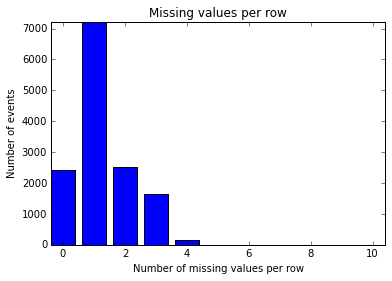

In [14]:
plt.bar(row_NaN.keys(), row_NaN.values(),align = 'center')
plt.xlabel('Number of missing values per row')
plt.ylabel('Number of events')
plt.title('Missing values per row')
plt.axis('tight')
# Mostly 1 NaN per a row, though significant amount, ~2000 events, has two features missing

In [14]:
# Removing NaNs by column, decided to remove all the end due to not significant statistics
to_remove_NaNs = ['domestictotal','productionbudget','runtime','openwdg','owtheaters']
for _ in to_remove_NaNs:
    df1 = df1[pd.notnull(df1[_])]
df1.isnull().sum(axis=0)   

distributor         0
domestictotal       0
genre               0
mpaarating          0
owtheaters          0
productionbudget    0
releasedate         0
runtime             0
tlg                 0
openwdg             0
title               0
dtype: int64

## 2. Exploratory Research:

In [15]:
df1.dtypes

distributor          object
domestictotal       float64
genre                object
mpaarating           object
owtheaters          float64
productionbudget    float64
releasedate          object
runtime             float64
tlg                 float64
openwdg             float64
title                object
dtype: object

In [16]:
# convert object to date
df1['releasedate'] = df1['releasedate'].apply(dateutil.parser.parse, dayfirst=False)
# calculate profitability
df1['profitability'] = df1['domestictotal'] - df1['productionbudget']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117b865d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119acf9d0>]], dtype=object)

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


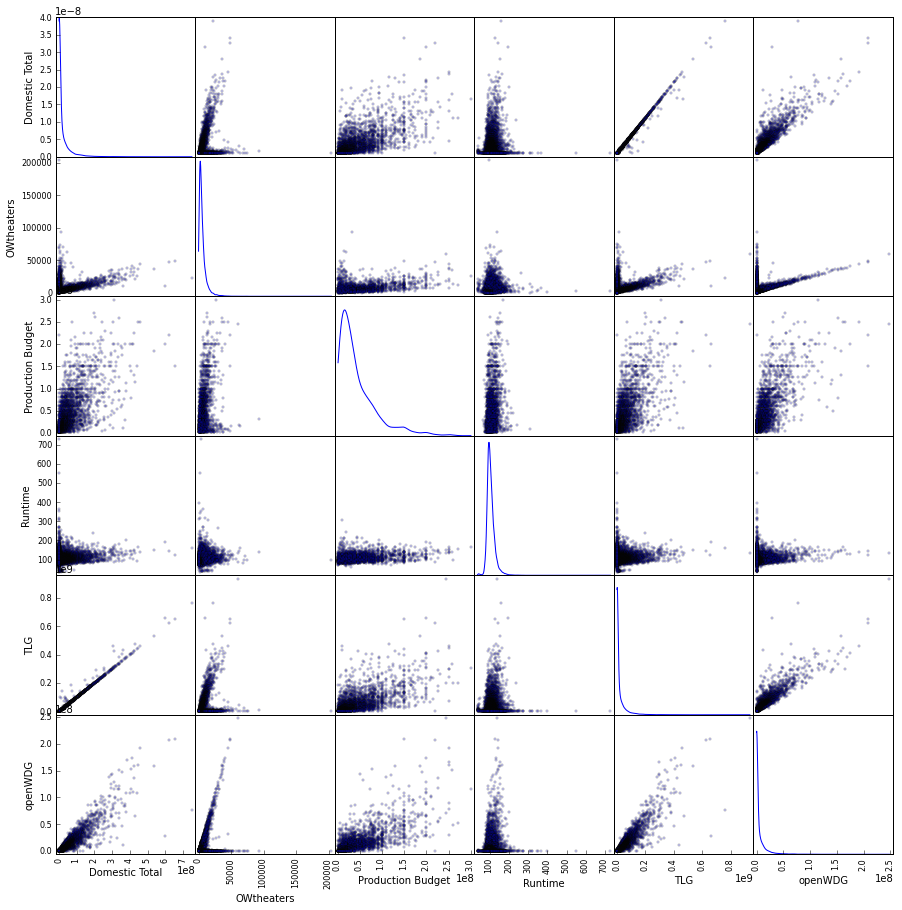

In [18]:
# Plot data
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df,alpha=0.2, figsize=(15,15),diagonal='kde')

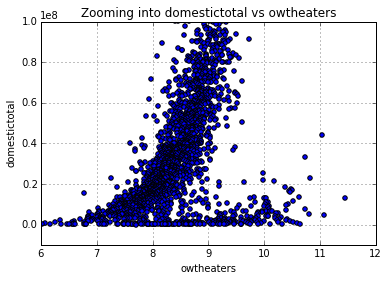

In [19]:
# zooming into structure with two components, the lower one - a word of caution (possibly no profit), let's see 
# below a distribution across genre for events in the lower component
plt.scatter(np.log(df1['owtheaters']),df1['domestictotal'])
plt.axis([6,12,-0.1e8,1e8])
plt.xlabel('owtheaters')
plt.ylabel('domestictotal')
plt.title('Zooming into domestictotal vs owtheaters')
plt.grid()

(-0.40000000000000002, 31.400000000000002, 0.0, 23.0)

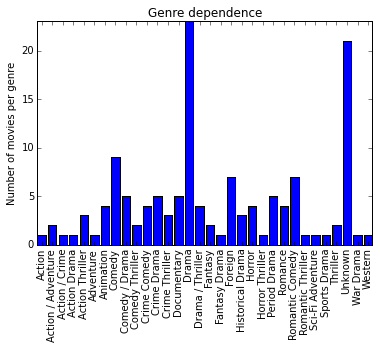

In [37]:
# Genre dependece of movies with ~0 domestictotal (possibly no profit)
low = df1[(df1['domestictotal'] <= 1.e6) & (np.log(df1['owtheaters']) > 0.8)].groupby('genre')
plt.bar(range(len(low['title'].count().index)),low['title'].count(), align = 'center')
plt.xticks(range(len(low['title'].count())),low['title'].count().index,rotation=90)
plt.ylabel('Number of movies per genre')
plt.title('Genre dependence')
plt.axis('tight')
# Spread all ove genre

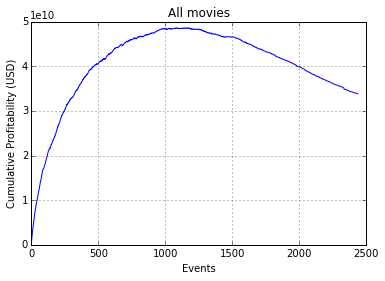

In [21]:
plt.plot(np.cumsum(df1['profitability']))
plt.ylabel('Cumulative Profitability (USD)')
plt.xlabel('Events')
plt.title('All movies')
plt.grid()

In [17]:
def error_propagation(value, err):
    """Returns statistical errors"""
    
    return ufloat(value,err)

In [153]:
def cumulative(data):
    """ Returns percentage of profitable and nonprofitable counts with statistical errors"""
    
    total = np.cumsum(data).reset_index(drop = True)
    count = 0.
    
    for i, x in np.ndenumerate(total):
        if i <= np.argmax(total):
            count += 1
    count_l = len(total) - count
    
    if count != 0:
        err = count / sqrt(count)    
    else:
        err = 0.
        
    if count_l != 0 :
        err_n = count_l / sqrt(count_l)
    else:
        err_n = 0.
    
    pr = error_propagation(count,err)  
    nr = error_propagation(count_l,err_n)
    
    profit  = (100 * pr / (pr + nr))
    lost = 100 - profit
    
    return (profit,lost)

In [155]:
# Calculating percentage of movies with/without profit on domestic market
print cumulative(df1['profitability'])[0],'% of movies that generate any profit on domestic market'
print cumulative(df1['profitability'])[1], '% of movies that do not generate any profit on domestic market'

44.6+/-1.0 % of movies that generate any profit on domestic market
55.4+/-1.0 % of movies that do not generate any profit on domestic market


In [19]:
# grouping by genre and calculating basic statistics
bygenre = df1.groupby('genre')['profitability'].agg([np.mean,np.std,np.min,np.max,len])
bygenre.head()

,mean,std,amin,amax,len
genre,,,,,
Action,2815126.823529,4.671320e+07,-143577375,163007020,102
Action / Adventure,56106101.188406,1.052878e+08,-96381145,403357910,69
Action / Crime,-3704937.888889,2.750823e+07,-71549530,46128601,18
Action Comedy,9532311.742424,4.551912e+07,-58736034,141719337,66
Action Drama,-9583201.571429,6.958008e+07,-136637525,149721524,21


(-0.40000000000000002,
 62.399999999999999,
 -129277559.58582444,
 262251202.79583883)

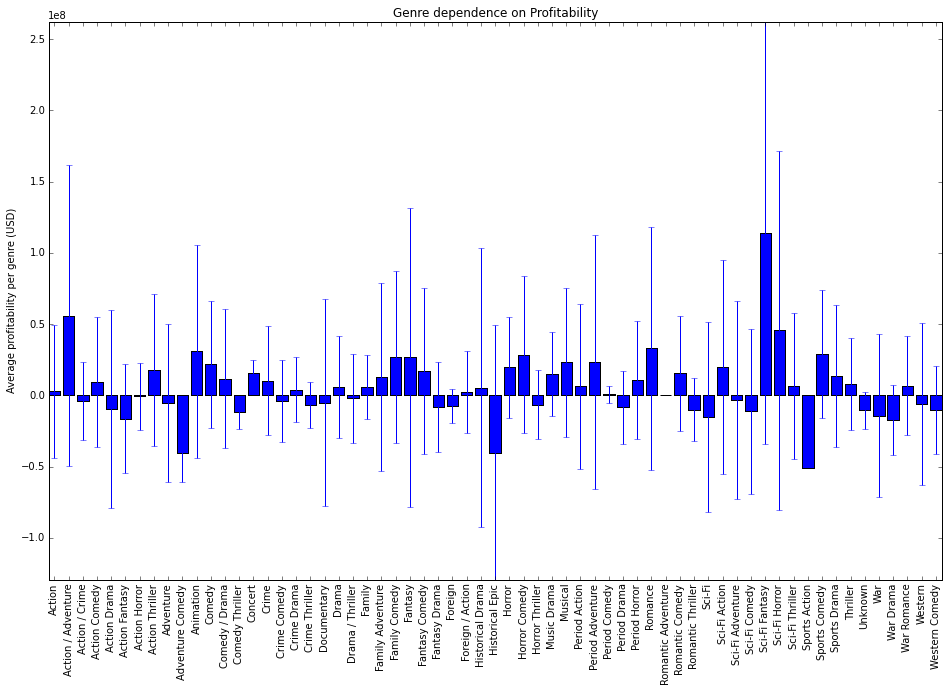

In [41]:
bygl = bygenre.index.tolist()
plt.figure(figsize = (16,10))
plt.bar(range(len(bygenre['mean'])), bygenre['mean'], align = 'center',yerr = bygenre['std'])
plt.xticks(range(len(bygl)),bygl,rotation=90)
plt.ylabel('Average profitability per genre (USD)')
plt.title('Genre dependence on Profitability')
plt.axis('tight')
# Std used as error bar

(-0.40000000000000002, 7.3999999999999995, -47238988.0, 316088295.0)

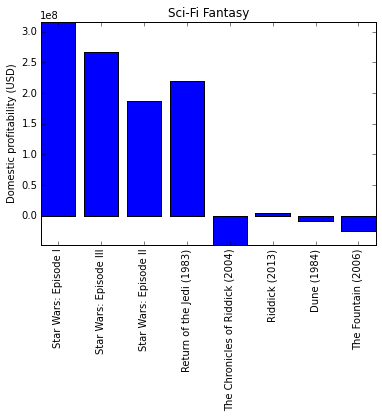

In [29]:
# Let's see the most profitable genre Sci-Fi Fanstasy => Surprise, surprise - it's all in Star Wars! 
SciFiFantasy = df1[df1['genre'] == 'Sci-Fi Fantasy']
pr = SciFiFantasy['profitability']
ti = SciFiFantasy['title']
plt.bar(range(len(pr)),pr,align = 'center')
plt.xticks(range(len(ti)),ti.tolist(),rotation=90)
plt.ylabel('Domestic profitability (USD)')
plt.title('Sci-Fi Fantasy')
plt.axis('tight')

(-0.40000000000000002, 62.399999999999999, 0.0, 344.0)

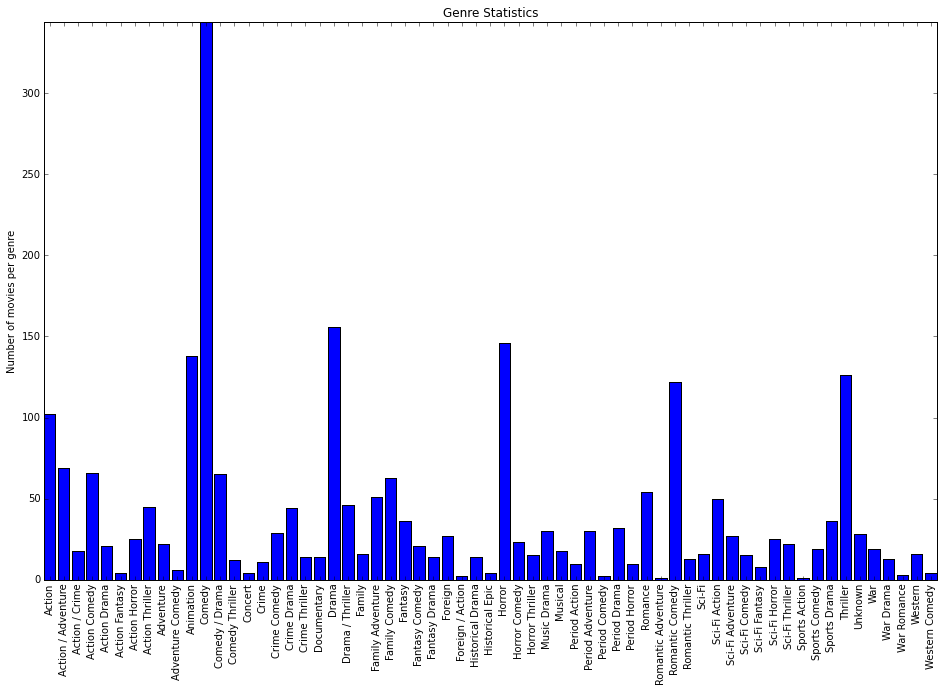

In [30]:
# Let's check the statistics and select the most common genre 
plt.figure(figsize = (16,10))
plt.bar(range(len(bygenre['len'])), bygenre['len'], align = 'center')
plt.xticks(range(len(bygl)),bygl,rotation=90)
plt.ylabel('Number of movies per genre')
plt.title('Genre Statistics')
plt.axis('tight')

In [20]:
# For further analysis select genre with at least 100 movies, and print out the list below
selected = bygenre[bygenre['len'] >= 100].index.tolist()
print 'Number of total events in selected genre = ', sum([_ for _ in bygenre['len'] if _ >= 100])
print 'The most common genre selected for models: '
print selected

Number of total events in selected genre =  1134.0
The most common genre selected for models: 
[u'Action', u'Animation', u'Comedy', u'Drama', u'Horror', u'Romantic Comedy', u'Thriller']


In [21]:
# Creating data frame including only data from selected Genre
newd = pd.DataFrame()
for item in selected:
    df2 = df1[df1['genre'] == item]
    newd = pd.concat([newd,df2])
print newd.shape
newd.head(4)

(1134, 12)


,distributor,domestictotal,genre,mpaarating,owtheaters,productionbudget,releasedate,runtime,tlg,openwdg,title,profitability
31,Universal,353007020,Action,PG-13,36760,190000000,2015-04-03,137,353007020,147187040,Furious 7 (2015),163007020
53,Sony / Columbia,304360277,Action,PG-13,25211,200000000,2012-11-09,143,304360277,88364714,Skyfall (2012),104360277
109,Universal,238679850,Action,PG-13,26620,160000000,2013-05-24,130,238679850,97375245,Fast & Furious 6 (2013),78679850
141,Paramount,215409889,Action,PG-13,15835,125000000,2000-05-24,123,215409889,57845297,Mission: Impossible II (2000),90409889


Action
(29.41176470588235+/-4.511558757925708, '% Profit')
(70.58823529411765+/-4.511558757925708, '% No Profit')

Animation
(67.3913043478261+/-3.9905164144772303, '% Profit')
(32.60869565217391+/-3.9905164144772303, '% No Profit')

Comedy
(61.91860465116279+/-2.618109374197254, '% Profit')
(38.08139534883721+/-2.618109374197254, '% No Profit')

Drama
(31.41025641025641+/-3.7162338197424214, '% Profit')
(68.58974358974359+/-3.7162338197424214, '% No Profit')

Horror
(71.91780821917808+/-3.7192664644171267, '% Profit')
(28.082191780821915+/-3.7192664644171267, '% No Profit')

Romantic Comedy
(57.377049180327866+/-4.477245883344629, '% Profit')
(42.622950819672134+/-4.477245883344629, '% No Profit')

Thriller
(50.79365079365079+/-4.453792853410804, '% Profit')
(49.20634920634921+/-4.453792853410804, '% No Profit')



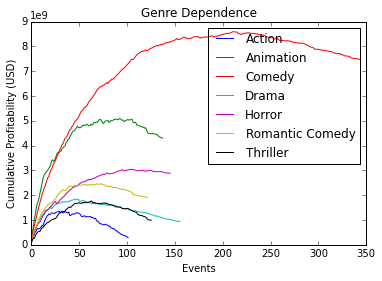

In [163]:
for j in selected:
    
    plt.plot(np.cumsum(newd[newd['genre'] == j]['profitability']),label=j)
    plt.legend()
    
    print j
    print (cumulative(newd[newd['genre'] == j]['profitability'])[0],
           '% Profit')
    
    print (cumulative(newd[newd['genre'] == j]['profitability'])[1],
           '% No Profit')
    print 
    
plt.xlabel('Events')
plt.ylabel('Cumulative Profitability (USD)')
plt.title('Genre Dependence')


## 3. Preprocessing for Model:
a) Removing Outliers
b) Scaling
c) Clustering (since there is interesting adn real structure in owtheaters)
d) Linear regression to pedict profitability for each cluster

In [23]:
# Removing outliers 
def reject_outliers(data):
    """Returns data within mean +- 2 sigma"""
    return data[abs(data - np.mean(data)) < 2. * np.std(data)]

In [24]:
to_reject = ['owtheaters','profitability']
newd01 = pd.DataFrame()
for i in to_reject:
    newd01 [i] = reject_outliers(newd[i])

In [25]:
newd01 = newd01[pd.notnull(newd01['profitability'])]
print newd01.shape
newd01.isnull().sum(axis=0)
test = newd01.join(newd['genre'],how='inner')

(1045, 2)


In [26]:
# Split data set into train and test
train, test = train_test_split(newd01,test_size = 0.2, random_state=42)
print len(train), len(test)

836 209


In [27]:
# Scale training set because scales of variables are order of magnitude different
normalizer = preprocessing.StandardScaler().fit(train[['owtheaters','profitability']])
scaled = normalizer.transform(train[['owtheaters','profitability']])

Number of clusters = 1
Cluster center  [[-0.57895297 -0.36511471]]


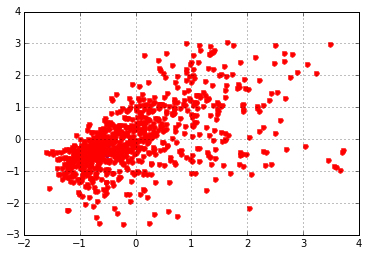

In [28]:
# Clustering Model:
ms = MeanShift()
ms.fit(scaled)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters = np.unique(len(cluster_centers))
print "Number of clusters = %d" % n_clusters
print "Cluster center ", cluster_centers

colors = ["r.","b.","k.","y.","c."]
for i in range(len(scaled)):
    plt.plot(scaled[i][0],scaled[i][1],colors[labels[i]],markersize= 10)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker = "x",s=150,linewidths=5)
plt.grid()
plt.show()

In [165]:
# Linear regression:
X = scaled[:,0]
X = sm.add_constant(X)
y = scaled[:,1]
model = sm.OLS(y,X)
fit = model.fit()
print fit.summary()
print
print 'Correlation to weak.'

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     337.6
Date:                Wed, 27 Apr 2016   Prob (F-statistic):           1.42e-63
Time:                        17:41:39   Log-Likelihood:                -1044.2
No. Observations:                 836   AIC:                             2092.
Df Residuals:                     834   BIC:                             2102.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const               0      0.029          0      1.0